# Word frequencies


Now that we have the abstracts in two nice neat .csv files, we need to download/import the packages needed, import the .csv files, and then can get on with the first part of the analysis. 

## Get ready 

As always, we start with a couple of code cells that load up and nickname some useful packages, then check file locations, then import files and check them. 


In [1]:
%%capture

# installing necessary pdf conversion packages via pip
# the '%%capture' at the top of this cell suppresses the output (which is normally quite long and annoying looking). 
# You can remove or comment it out if you prefer to see the output. 
!pip install nltk


In [2]:
%%capture

import os                         # os is a module for navigating your machine (e.g., file directories).
import nltk                       # nltk stands for natural language tool kit and is useful for text-mining. 
from nltk import word_tokenize    # and some of its key functions

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet                    # Finally, things we need for lemmatising!
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
nltk.download('averaged_perceptron_tagger')        # Like a POS-tagger...
nltk.download('wordnet')
nltk.download('webtext')
from nltk.corpus import webtext

import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import statistics
import datetime
date = datetime.date.today()

import codecs
import csv                        # csv is for importing and working with csv files

from collections import Counter

import statistics
import re                         # things we need for RegEx corrections
import matplotlib.pyplot as plt
import string 

import math 

English_punctuation = "-!\"#$%&()'*-–+,./:;<=>?@[\]^_`{|}~''“”"      # Things for removing punctuation, stopwords and empty strings
table_punctuation = str.maketrans('','', English_punctuation)

In [3]:
print(os.listdir("..\\output")  )                                # check 'results' folder is not empty/has correct stuff

['all_abstracts_no_null_texts.csv', 'matched_abstracts_no_null_texts.csv', 'text_match_results.csv']


## Import

Having checked the contents of the output folder and seen the files we expected to see, we can now import and check them. 

In [10]:
all_texts = pd.read_csv('..\\output\\all_abstracts_no_null_texts.csv')            # one for all of the texts and then
matched_texts = pd.read_csv('..\\output\\matched_abstracts_no_null_texts.csv')    # one for just those that match the keyword

In [11]:
print (len(all_texts))                        # it is always useful to double check that the length matches your expectations
print (len(matched_texts))                    # in this case, we already know how many rows to expect in each file. 

33979
906


## Get some basic stats about how texts are spread out over time

We know that all of the rows in the files have at least two columns with contents - 'Year' and 'Text'. This means that it is probably a useful thing to get a little schematic and/or table that counts row according to year. Let's do that now! 

In [19]:
all_counts_by_year = all_texts['Year'].value_counts()         # this creates a little table with two columns - year and count
print(all_counts_by_year)                                     # however, when we print it we can see it has no headers,
                                                              # is not in order, etc. 

2013.0    2373
2001.0    2336
2014.0    2240
2004.0    2205
2016.0    2040
2011.0    1967
2015.0    1951
2008.0    1896
2012.0    1871
2010.0    1716
2009.0    1704
2021.0    1570
2007.0    1541
2005.0    1520
2019.0    1437
2006.0    1422
2002.0    1266
2003.0     996
2020.0     693
2017.0     651
2018.0     584
Name: Year, dtype: int64


In [20]:
all_counts_by_year = pd.DataFrame(all_counts_by_year)                      # so we convert the table to a data frame
all_counts_by_year = all_counts_by_year.rename(columns={"Year": "Counts"}) # name the columns
all_counts_by_year = all_counts_by_year.rename_axis('Year').reset_index()  # set the axis to year and reset the index
all_counts_by_year = all_counts_by_year.sort_values(by=['Year'])           # and sort by value of year.
print(all_counts_by_year)                                                  # Let's just check it worked. 

      Year  Counts
1   2001.0    2336
16  2002.0    1266
17  2003.0     996
3   2004.0    2205
13  2005.0    1520
15  2006.0    1422
12  2007.0    1541
7   2008.0    1896
10  2009.0    1704
9   2010.0    1716
5   2011.0    1967
8   2012.0    1871
0   2013.0    2373
2   2014.0    2240
6   2015.0    1951
4   2016.0    2040
19  2017.0     651
20  2018.0     584
14  2019.0    1437
18  2020.0     693
11  2021.0    1570


In [21]:
matched_counts_by_year = matched_texts['Year'].value_counts()      # repeat the process for the matched_texts file
matched_counts_by_year = pd.DataFrame(matched_counts_by_year)                        # again, turn it into a data frame
matched_counts_by_year = matched_counts_by_year.rename(columns={"Year": "Matches"})  # name the columns
matched_counts_by_year = matched_counts_by_year.rename_axis('Year').reset_index()    # rename axis, reset index
matched_counts_by_year = matched_counts_by_year.sort_values(by=['Year'])             # sort by value of year
print(matched_counts_by_year)                                                        # and check that it looks correct. 

2016.0    92
2013.0    86
2014.0    76
2015.0    63
2012.0    61
2019.0    56
2011.0    55
2021.0    53
2008.0    40
2010.0    40
2001.0    37
2017.0    32
2018.0    32
2020.0    30
2009.0    26
2005.0    25
2007.0    23
2004.0    23
2006.0    21
2002.0    19
2003.0    16
Name: Year, dtype: int64


In [49]:
counts_year = all_counts_by_year.merge(matched_counts_by_year, on='Year', how='left') # now, combine the two data frames
print(counts_year)                                                                    # and have a look at it

      Year  Counts  Matches
0   2001.0    2336       37
1   2002.0    1266       19
2   2003.0     996       16
3   2004.0    2205       23
4   2005.0    1520       25
5   2006.0    1422       21
6   2007.0    1541       23
7   2008.0    1896       40
8   2009.0    1704       26
9   2010.0    1716       40
10  2011.0    1967       55
11  2012.0    1871       61
12  2013.0    2373       86
13  2014.0    2240       76
14  2015.0    1951       63
15  2016.0    2040       92
16  2017.0     651       32
17  2018.0     584       32
18  2019.0    1437       56
19  2020.0     693       30
20  2021.0    1570       53


In [50]:
counts_year = counts_year.set_index('Year')                     # set the year as the index
counts_year = counts_year.rename(columns={'Counts': 'Total'})   # rename the 'Counts' column to 'Total'
counts_year = counts_year.sort_values(by='Year')                # sort them by year
print(counts_year)                                              # and have a look. Nice!

        Total  Matches
Year                  
2001.0   2336       37
2002.0   1266       19
2003.0    996       16
2004.0   2205       23
2005.0   1520       25
2006.0   1422       21
2007.0   1541       23
2008.0   1896       40
2009.0   1704       26
2010.0   1716       40
2011.0   1967       55
2012.0   1871       61
2013.0   2373       86
2014.0   2240       76
2015.0   1951       63
2016.0   2040       92
2017.0    651       32
2018.0    584       32
2019.0   1437       56
2020.0    693       30
2021.0   1570       53


In [52]:
print(counts_year['Total'].sum())                                # I worry too much sometimes
print(counts_year['Matches'].sum())                              # but why not check that the numbers still add up? 

33979
906


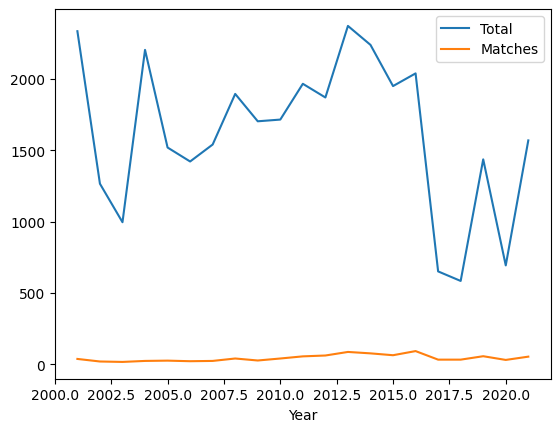

In [60]:
counts_year.plot()                                  # create a plot from the combined, re-indexed and renamed data frame
plt.show()                                          # have a look at the plot

In [63]:
plt.savefig('..\\output\\abstract_count.jpg')    # we can right click on the plot above to save it, or save it via command

<Figure size 640x480 with 0 Axes>

## Count word frequencies - 'bag of words'

Now that we have some basic descriptive stats about how many abstracts were imported properly with text in the 'Text' column, we can get on to the actual natural language processing steps. The most basic NLP option is to count the most frequent words found in the two sets of abstracts - meaning we need to find the most frequent words found in ALL of the abstracts and then compare that to the most frequnet words found in only those abstracts that contain a keyword of interest. 

To this end, we use the 'bag of words' method which whacks all of the words from all of the texts together, turns them into 'tokens' then processes to make them as unified as possible by removing uppercase letters, punctuation, digits, empty strings, stop words (e.g. 'the', 'and', 'for', etc. ) and word forms (e.g. pluralisations, verb endings, etc. ). 

Let's demo this with a simple example. If the text we want to 'bag of words' is "The cat named Cat was one of 5 cats." it would become a list of stemmed word-tokens like 
'''[[cat]
[name]
[cat]
[be]
[cat]]''' 
and the most common word would obviously be '''[cat]'''. 

Applying the 'bag of words' method to our texts is not so trivial, but should also be more enlightening. We would expect that the most common words from all of the texts would be similar to, but not identical to, the most common words from only the abstracts that contain a keyword of interest.

This bag of words approach ignores years, session codes, authors and everything else. Subsetting the texts by those things might be useful later. 

In [64]:
def bag_of_words_analysis(input, how_many):     # define a 'bag of words' function with 2 arguments, an input and a quantity 
    holding_string = ""                                                        # that creates a temporary variable
    for text in input['Text']:                                                 # looks at the 'Text' column for the input
        holding_string += text                                                 # fills up the temp variable with the text
    holding_string = word_tokenize(holding_string)                             # word tokenises that text
    holding_string = [word.lower() for word in holding_string]                 # remove uppercase letters
    holding_string = [w.translate(table_punctuation) for w in holding_string]  # removes punctuation
    holding_string = (list(filter(lambda x: x, holding_string)))               # removes andy empty strings
    holding_string = [token for token in holding_string if not token.isdigit()]  # removes digits
    holding_string = [token for token in holding_string if token not in stop_words]  # removes stopwords
    holding_string = [porter.stem(token) for token in holding_string]                # stems the word-tokens
    list_for_count = []                                                              # and creates an empty list
    for token in holding_string:                                         # then iterates over the tokens
        list_for_count.append(token)                                     # appending them to the list
    counts = Counter(list_for_count)                                     # applies the Counter function imported earlier 
    return counts.most_common(how_many)                                  # and returns the tokens with highest counts 
                                                                         # up to the quantity specified as an argument

In [71]:
most_frequent_all = bag_of_words_analysis(all_texts, 15)   # apply bag of words function to all texts, and save the output table
                                                           # this will take a while. 

In [77]:
most_frequent_all = pd.DataFrame(most_frequent_all)             # convert the saved output as a data frame
most_frequent_all = most_frequent_all.rename(columns={0: "Word", 1: "All count" }) # name the columns
print(most_frequent_all)                                                  # Let's just check it worked. print(most_frequent_all)

         Word  All count
0        gene      65261
1     patient      56209
2       mutat      52985
3        none      43226
4       genet      40114
5       studi      30924
6         use      27077
7        case      24921
8      result      24489
9      associ      23703
10    analysi      23258
11     diseas      22849
12     famili      22676
13     clinic      21455
14  chromosom      21175


In [80]:
most_frequent_matched = bag_of_words_analysis(matched_texts, 15) # apply the bag of words function to matched texts, and save

In [81]:
most_frequent_matched = pd.DataFrame(most_frequent_matched)      # convert it to a data frame
most_frequent_matched = most_frequent_matched.rename(columns={0: "Word", 1: "Matched count" }) # name the columns
print(most_frequent_matched)                                                  # Let's just check it worked. print(most_frequent_all)

         Word  Matched count
0        none           2273
1     patient           1985
2        gene           1853
3       genet           1151
4      disord           1056
5       delet           1056
6      autism           1042
7     syndrom           1017
8       mutat            940
9        case            891
10         de            873
11        asd            865
12     clinic            848
13  chromosom            824
14     associ            816


In [85]:
most_frequent = most_frequent_all.merge(most_frequent_matched, on='Word', how='outer') # combine the two data frames via 'outer'
                                                                                       # to get the total list of all words
print(most_frequent)

         Word  All count  Matched count
0        gene    65261.0         1853.0
1     patient    56209.0         1985.0
2       mutat    52985.0          940.0
3        none    43226.0         2273.0
4       genet    40114.0         1151.0
5       studi    30924.0            NaN
6         use    27077.0            NaN
7        case    24921.0          891.0
8      result    24489.0            NaN
9      associ    23703.0          816.0
10    analysi    23258.0            NaN
11     diseas    22849.0            NaN
12     famili    22676.0            NaN
13     clinic    21455.0          848.0
14  chromosom    21175.0          824.0
15     disord        NaN         1056.0
16      delet        NaN         1056.0
17     autism        NaN         1042.0
18    syndrom        NaN         1017.0
19         de        NaN          873.0
20        asd        NaN          865.0


In [86]:
most_frequent.to_csv('..\\output\\most_frequent_comparison.csv')  # write out the joined most frequent words to a .csv
                                                                  # again, with a clear and useful name

C:\Users\mzyssjkc\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


### Word Frequency by year

In [ ]:

def track_word_over_time(input, target_word):
    years = input['Year'].drop_duplicates()
    target_counts = []
    for year in years:
        year_bag = ""
        for text in input['Text'][input['Year']==year]:
            year_bag += text
        year_bag = word_tokenize(year_bag)
        year_bag = [word.lower() for word in year_bag]
        year_bag = [w.translate(table_punctuation) for w in year_bag]
        year_bag = (list(filter(lambda x: x, year_bag)))
        year_bag = [token for token in year_bag if not token.isdigit()]
        year_bag = [token for token in year_bag if token not in stop_words]
        year_bag = [porter.stem(token) for token in year_bag]
        list_for_count = []
        for token in year_bag:
            list_for_count.append(token)
        counts = Counter(list_for_count)
        target_counts.append(counts[target_word])
        
    target_word_by_year = pd.DataFrame(list(zip(years, target_counts)), columns = ['Year', str(target_word)])
    return target_word_by_year


In [ ]:
ASD = track_word_over_time(no_null_texts, 'asd')
autism = track_word_over_time(no_null_texts, 'autism')
autistic = track_word_over_time(no_null_texts, 'autist')
asperger = track_word_over_time(no_null_texts, 'asperger')

target_words = ASD.merge(autism, on='Year').merge(asperger, on='Year').merge(autistic, on='Year')

In [ ]:
target_words = target_words.set_index('Year')
target_words = target_words.sort_values(by=['Year'])
target_words.plot.line()
plt.show()

In [ ]:
diseas = track_word_over_time(no_null_texts, 'diseas')
disord = track_word_over_time(no_null_texts, 'disord')
condition = track_word_over_time(no_null_texts, 'condit')
syndrom = track_word_over_time(no_null_texts, 'syndrom')

target_words_2 = diseas.merge(disord, on='Year').merge(syndrom, on='Year').merge(condition, on='Year')

In [ ]:
target_words_2 = target_words_2.set_index('Year')
target_words_2 = target_words_2.sort_values(by=['Year'])
target_words_2.plot.line()
plt.show()

### Word frequency by session code
